# Recommendation System

## Team
- [Ananda Heino](https://www.linkedin.com/in/ananda-heino-coelho-72154454/)
- [Silvana Santos](https://www.linkedin.com/in/silvana-santos-1a1546209/)

## Dataset
- [MovieLens](https://files.grouplens.org/datasets/movielens/)

## Brief descriptions of the data:

- ml-data.tar.gz   
    - Compressed tar file.  
    - To rebuild the u data files do this:
        - gunzip ml-data.tar.gz
        - tar xvf ml-data.tar
        - mku.sh

- u.data  
    - The full u data set, 100000 ratings by 943 users on 1682 items.
    - Each user has rated at least 20 movies. 
    - Users and items are numbered consecutively from 1.  
    - The data is randomly ordered. 
    - This is a tab separated list of 
        -  user id | item id | rating | timestamp. 
        - The time stamps are unix seconds since 1/1/1970 UTC   

- u.info
    - The number of users, items, and ratings in the u data set.

- u.item    
    - Information about the items (movies); 
    - this is a tab separated list of
         - movie id | movie title | release date | video release date |
         - IMDb URL | unknown | Action | Adventure | Animation |
         - Children's | Comedy | Crime | Documentary | Drama | Fantasy |
         - Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
         - Thriller | War | Western |
         
         - The last 19 fields are the genres, a 1 indicates the movie is of that genre, a 0 indicates it is not; movies can be in several genres at once.
         - The movie ids are the ones used in the u.data data set.

- u.genre   
    - A list of the genres.

- u.user     
    - Demographic information about the users;
    - this is a tab separated list of 
        - user id | age | gender | occupation | zip code
     - The user ids are the ones used in the u.data data set.

- u.occupation 
    - A list of the occupations.

In [25]:
#!conda install -c -y conda-forge lightfm
#!conda install pickle
#!pip install statsmodels

In [26]:
import pickle
import pandas as pd
from lightfm.data import Dataset
from lightfm import LightFM
import numpy as np
import re
import time
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from dateutil.parser import parse
import plotly.express as px

# Reading the data:
- `u.data`
- `u.user`

In [27]:
df_data = pd.read_csv('data/u.data', sep ='\t', header = None)

In [28]:
df_data.rename(columns = {0:'user_id', 1:'item_id', 2:'rating', 3:'timestamp'}, inplace = True)
df_data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [29]:
df_user = pd.read_csv('data/u.user', sep ='|', header = None)

In [30]:
df_user.rename(columns = {0:'user_id', 1:'age', 2:'gender', 3:'occupation', 4: 'zipcode'}, inplace = True)
df_user.head()

,user_id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [31]:
df_data = pd.merge(df_data, df_user, how = 'inner', on = 'user_id')
df_data.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zipcode
0,196,242,3,881250949,49,M,writer,55105
1,196,393,4,881251863,49,M,writer,55105
2,196,381,4,881251728,49,M,writer,55105
3,196,251,3,881251274,49,M,writer,55105
4,196,655,5,881251793,49,M,writer,55105


In [32]:
df_data.describe().round(2)

,user_id,item_id,rating,timestamp,age
count,100000.00,100000.00,100000.00,1.000000e+05,100000.00
mean,462.48,425.53,3.53,8.835289e+08,32.97
std,266.61,330.80,1.13,5.343856e+06,11.56
min,1.00,1.00,1.00,8.747247e+08,7.00
25%,254.00,175.00,3.00,8.794487e+08,24.00
50%,447.00,322.00,4.00,8.828269e+08,30.00
75%,682.00,631.00,4.00,8.882600e+08,40.00
max,943.00,1682.00,5.00,8.932866e+08,73.00


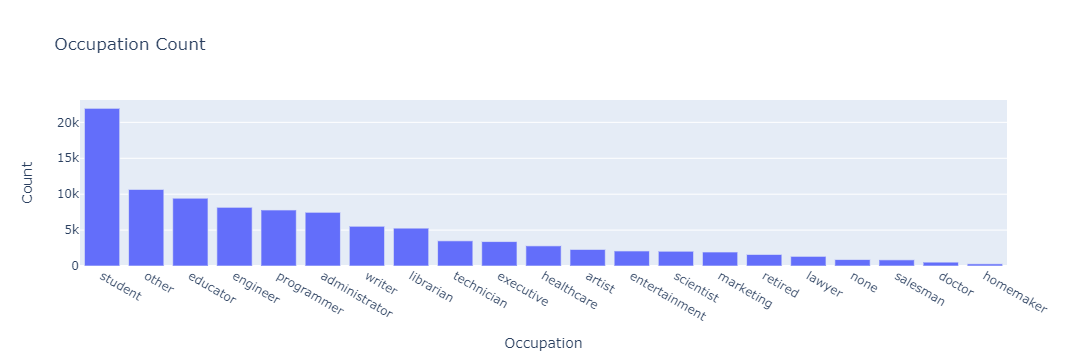

In [33]:
df = pd.DataFrame(df_data['occupation'].value_counts())
df = df.reset_index()
fig = px.bar(df, x='index', y='occupation', title='Occupation Count', labels={'occupation':'Count', 'index':'Occupation'})
fig.show()

### We can see that most of the users are students.

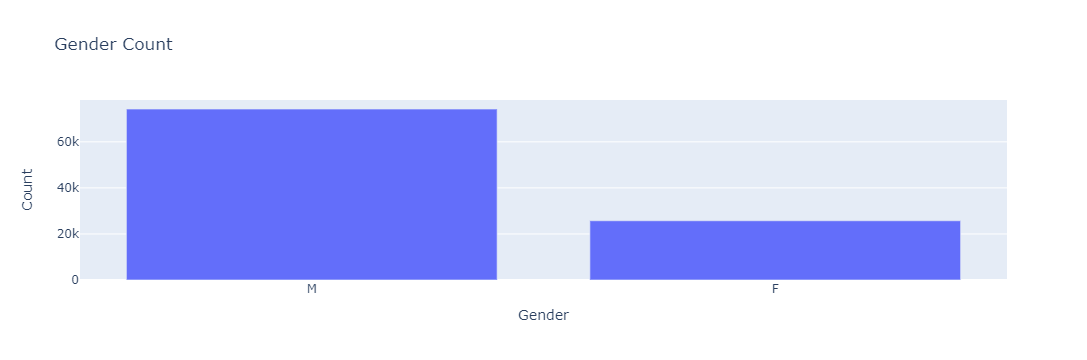

In [34]:
df = pd.DataFrame(df_data['gender'].value_counts())
df = df.reset_index()
fig = px.bar(df, x='index', y='gender', title='Gender Count', labels={'gender':'Count', 'index':'Gender'})
fig.show()

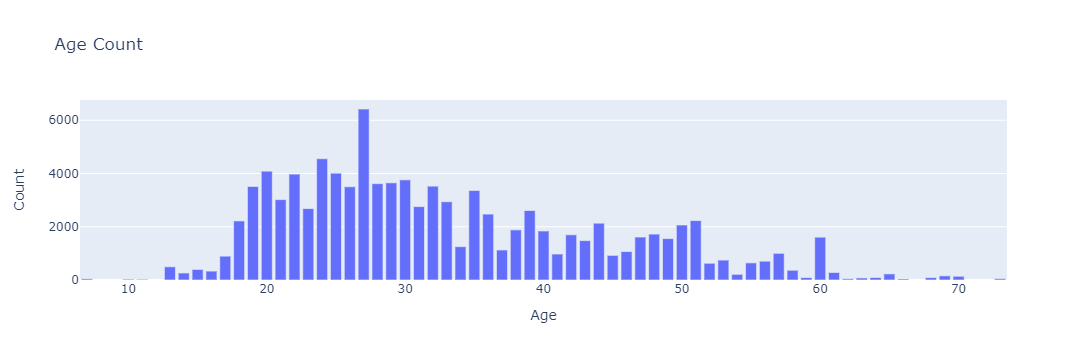

In [35]:
df = pd.DataFrame(df_data['age'].value_counts())
df = df.reset_index()
fig = px.bar(df, x='index', y='age', title='Age Count', labels={'age':'Count', 'index':'Age'})
fig.show()

### We can see that most of the users are male.
 - thus, the dataset is unbalanced 


***
## Plotting Gender and Occupation for each rating value

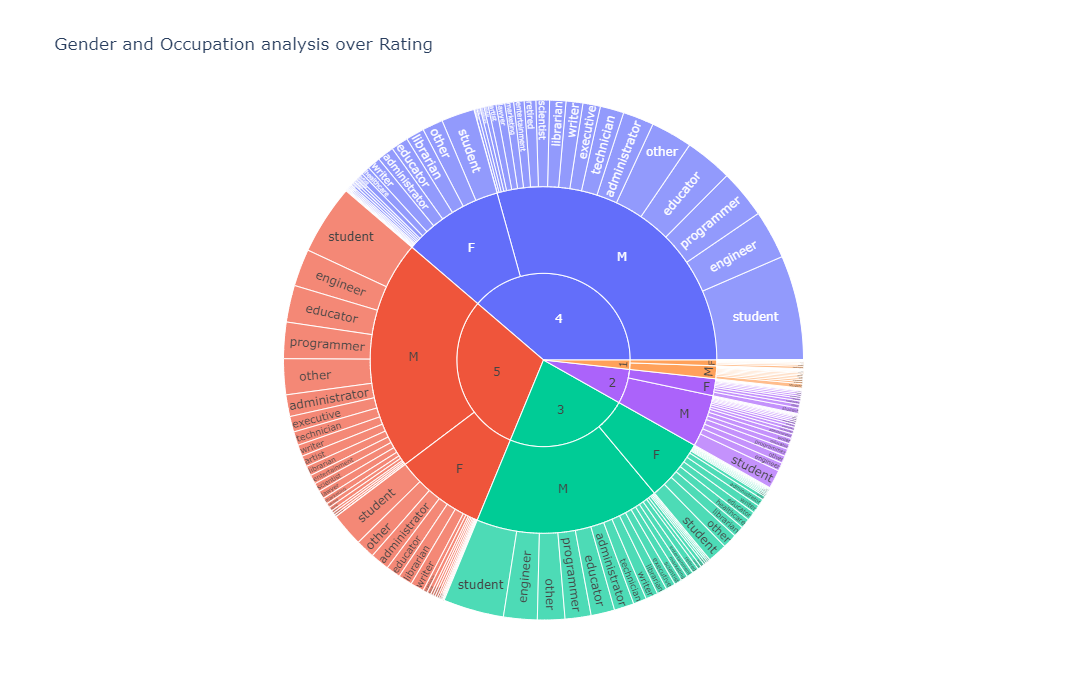

In [36]:
fig = px.sunburst(df_data, path=['rating', 'gender', 'occupation'], values='rating', title='Gender and Occupation analysis over Rating', height=700)
display(fig)

In [37]:
df_data.isna().sum()

user_id       0
item_id       0
rating        0
timestamp     0
age           0
gender        0
occupation    0
zipcode       0
dtype: int64

In [38]:
df_data.shape

(100000, 8)

In [39]:
df_data.dtypes

user_id        int64
item_id        int64
rating         int64
timestamp      int64
age            int64
gender        object
occupation    object
zipcode       object
dtype: object

In [40]:
df_data['rating'].unique()

array([3, 4, 5, 2, 1])

### Reading Items information from `u.item`

In [41]:
#reading the file
df_item = pd.read_csv('data/u.item', sep ='|', header = None, encoding = 'iso-8859-1')
# renaming the columns
df_item.rename(columns = {0:'item_id', 1:'movie_title', 2:'release_date', 3:'drop', 4: 'drop2', 5: 'unknown', 6: 'action', 7: 'adventure', 
                          8: 'animation', 9: 'children', 10: 'comedy', 11: 'crime', 12: 'documentary', 13: 'drama', 14: 'fantasy', 15: 'film_noir',
                          16: 'horror', 17: 'musical', 18: 'mystery', 19: 'romance', 20: 'sci_fi', 21: 'thriller', 22: 'war', 23: 'western'}, inplace = True)
# droping two unnimportant 
df_item.drop(['drop', 'drop2'], axis = 1, inplace = True)

In [42]:
df_data = pd.merge(df_data, df_item, how = 'inner', on = 'item_id')
df_data.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zipcode,movie_title,release_date,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df_data['release_date'] = pd.to_datetime(df_data['release_date'])

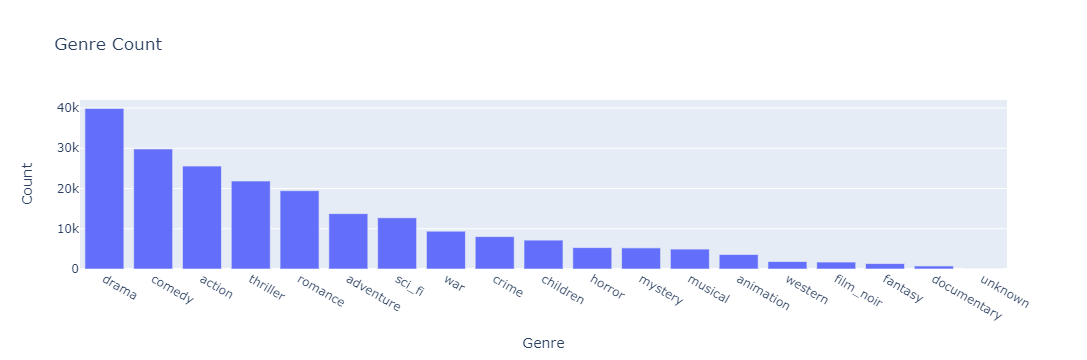

In [53]:
df_genre = pd.DataFrame(df_data.drop(['user_id','item_id','rating','timestamp',
                                      'age','gender','occupation','zipcode',
                                      'movie_title', 'release_date'], axis=1).sum())
df_genre = df_genre.reset_index()
df_genre = df_genre.sort_values(0, ascending=False)
fig = px.bar(df_genre, x='index', y=0, title='Genre Count', labels={'0':'Count', 'index':'Genre'})
fig.show()

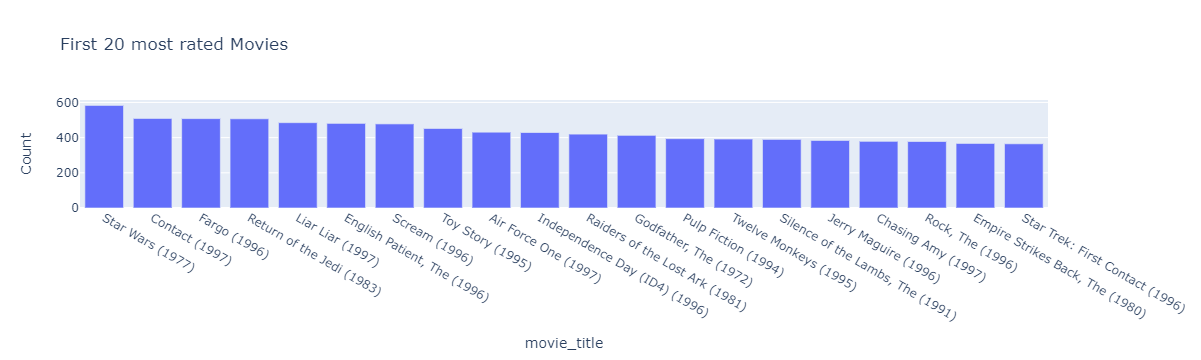

In [62]:
df_movies_count = pd.DataFrame(df_data['movie_title'].value_counts())
df_movies_count = df_movies_count.reset_index()
fig = px.bar(df_movies_count[:20], x='index', y='movie_title', title='First 20 most rated Movies', labels={'movie_title':'Count', 'index':'movie_title'})
fig.show()

In [64]:
df_movies_count.rename(columns = {'index':'movie_title', 'movie_title':'movie_counts'}, inplace=True)
df_movies_count

,movie_title,movie_counts
0,Star Wars (1977),583
1,Contact (1997),509
2,Fargo (1996),508
3,Return of the Jedi (1983),507
4,Liar Liar (1997),485
...,...,...
1659,"Eye of Vichy, The (Oeil de Vichy, L') (1993)",1
1660,Lashou shentan (1992),1
1661,Liebelei (1933),1
1662,"Man from Down Under, The (1943)",1


In [ ]:
df_item_mean = df_data[["movie_title", "rating"]].groupby('movie_title').mean().reset_index().round(2)
df_data = pd.merge(df_data, df_item, how = 'inner', on = 'item_id')
df_item_mean = pd.merge(df_item_mean, df_movies_count, how='inner', on='movie_title')

In [87]:
df_item_mean.sort_values('movie_counts', ascending=False, inplace=True)
df_item_mean

,movie_title,rating,movie_counts
1398,Star Wars (1977),4.36,583
333,Contact (1997),3.80,509
498,Fargo (1996),4.16,508
1234,Return of the Jedi (1983),4.01,507
860,Liar Liar (1997),3.16,485
...,...,...,...
633,"Great Day in Harlem, A (1994)",5.00,1
1111,"Other Voices, Other Rooms (1997)",3.00,1
620,Good Morning (1971),1.00,1
606,Girls Town (1996),3.00,1


In [77]:
df_item_mean[df_item_mean['movie_counts']>400]

,movie_title,rating,movie_counts
32,Air Force One (1997),3.63,431
333,Contact (1997),3.80,509
460,"English Patient, The (1996)",3.66,481
498,Fargo (1996),4.16,508
612,"Godfather, The (1972)",4.28,413
744,Independence Day (ID4) (1996),3.44,429
860,Liar Liar (1997),3.16,485
1205,Raiders of the Lost Ark (1981),4.25,420
1234,Return of the Jedi (1983),4.01,507
1284,Scream (1996),3.44,478


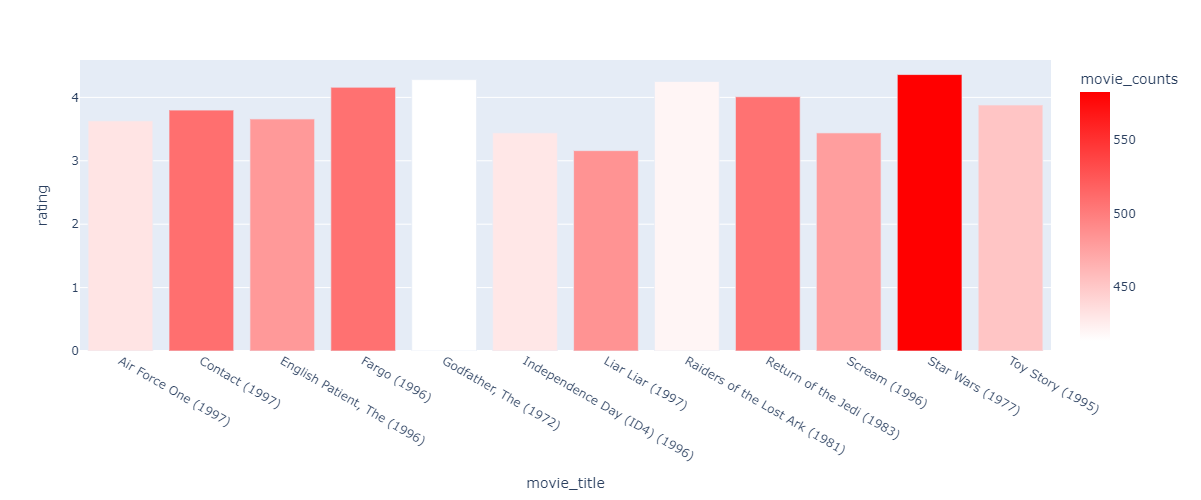

In [82]:
fig = px.bar(df_item_mean[df_item_mean['movie_counts']>400], y="rating", x="movie_title", 
             color="movie_counts", color_continuous_scale=['white', 'red'], height=500)

fig.show()

## Building a Similarity Matrix